# Asteroid detection
Mélina VANEL
19/02/2021

The purpose of this notebook is to estimate how long ( in days ) an asteroid would be visible by a telescope given some parameters like minimum magnitude detectable which depends on the integration time, the detector size, the FOV...  


The final goal is to study the possibilty to find a strategy to be able to detected asteroids above 100m diameter with a 99.9% probability. That is why in this study we will often compute quantities for 100m asteroids because it represents the worst case ( less bright as they are the smallest asteroids we want to detect ).

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import colorbar, pcolor, show
from matplotlib import ticker,cm
import pandas as pd
import matplotlib as mpl
from scipy.integrate import quad  

In [47]:
###################
# Constants
###################

h = 6.62607004e-34              # Planck Constant

c = 299792458.0                 # Speed of light

G = 6.67*10**(-11)              # Gravitational constant

M = 1.989*10**(30)              # Solar mass

#### Diameter, absolute magnitude and apparent magnitude  
  
First of all, it is important to find the link between the diameter and the Absolute Magnitude which is :
\begin{align} D=\frac{1329km*10^{\frac{-H}{5}}}{\sqrt{p_v}}\end{align} 

With $D$ the diameter in km, $H$ the absolute magnitude and $p_v$ the geometric albedo.  

**Source** : *Physical properties of near-Earth asteroids from thermal infrared observations and thermal modeling
/ Marco Delbo*

The absolute magnitude is measured by the telescope but the geometric albedo $p_v$ cannot be measured, that is why we decided to take $p_v$ between 0.03 and 0.15 as its distribution among C type asteroids ( which are the most abundant ) is :

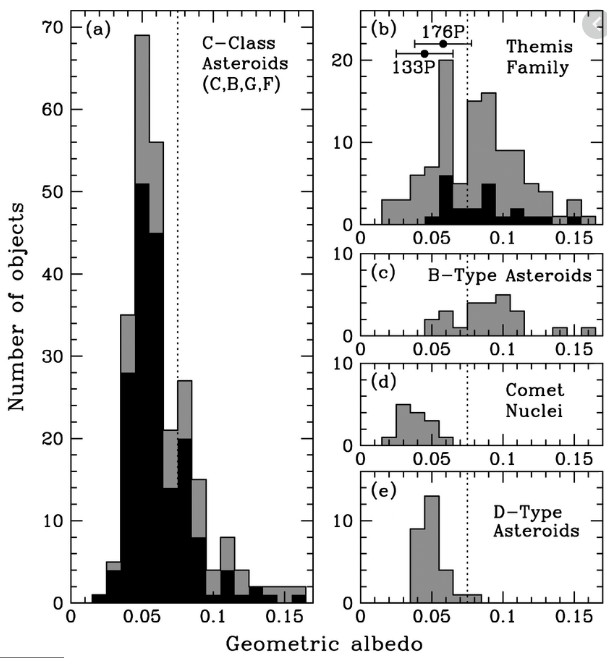

In [48]:
from IPython.display import Image
Image("pv.png",width=300)

In [49]:
def D_to_abs_mag(D,p_v):
    '''
    Parameters
    ----------
    D : Diameter (km)
    p_v : Geometric Albedo ( from 0.03 to 0.15 for NEO )

    Returns
    -------
    H : Absolute Magnitude
    '''
    return -5*np.log10(np.sqrt(p_v)*D/1329)

def abs_mag_to_D(H,pv):
    '''
    Parameters
    ----------
    H : Absolute Magnitude
    pv : Geometric Albedo ( from 0.03 to 0.15 for NEO )

    Returns
    -------
    H : Diameter in meter (m)
    '''    
    return 1329*10**(-H/5)/(np.sqrt(pv))*10**3

Given two distances :
- distance to the Sun $d_{sun}$ in UA
- distance to the observer $d_{obs}$ in UA
  
it is then possible to compute the apparent magnitude m from absolute magnitude H :

\begin{align} m = H + 5log_{10}\left ( \frac{d_{sun}*d_{obs}}{1UA^2}\right ) -2.5log_{10}(q)\end{align}

With q the phase angle, that we will assume to be $0.290+0.684*0.15$  

**Source :** *https://en.wikipedia.org/wiki/Absolute_magnitude*

In [50]:
def abs_mag_to_mag(H,d_sun_ast,d_obs_ast):
    '''
    Parameters
    ----------
    H : Absolute Magnitude
    d_sun_ast : distance bewteen Sun and NEO ( /!\ UA )
    d_obs_ast : distance bewteen Satellite and NEO ( /!\ UA )
    
    Returns
    -------
    m : Apparent Magnitude
    '''    
    # Distance in UA
    q=0.290+0.684*0.15
    return H + 5*np.log10(d_sun_ast*d_obs_ast) - 2.5*np.log10(q)

<ipython-input-51-2a2331f3a702>:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(X, Y, mag_app)               # from magnitude 18 because if the asteroid is very close to the Sun and the observer


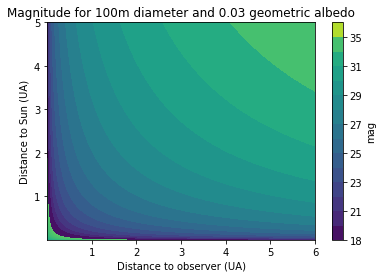

In [51]:
D_SUN = np.linspace(0.00001,6,1000)     # in UA
D_OBS = np.linspace(0.00001,5,1000)     # in UA
X, Y = np.meshgrid(D_SUN, D_OBS)

mag_abs=D_to_abs_mag(0.1,0.03)          # absolute magnitude of a 100m diameter asteroid with pv = 0.03
mag_app = abs_mag_to_mag(mag_abs,X,Y)

fig, ax = plt.subplots()
plt.pcolor(X, Y, mag_app)               # from magnitude 18 because if the asteroid is very close to the Sun and the observer 
                                        # the magnitude will be very low and it won't be easy to put very low and high magnitude
                                        # on the same graph that is why there is green in the back left corner
level = [18,20,21,22,23,24,25,26,27,28,29,30,31,32,35,40]
cs = ax.contourf(X, Y, mag_app,level)

cbar = fig.colorbar(cs)
cbar.ax.set_ylabel('mag')
plt.xlabel('Distance to observer (UA)')
plt.ylabel('Distance to Sun (UA)')
plt.title('Magnitude for 100m diameter and 0.03 geometric albedo')
plt.show()

In order to be able to determine if an asteroid is detected or not it is then necessary to compute the flux of a given source with a certain magnitude m. We assume that a source of magnitude 0 has a flux of $3.6*10^6$ ph/s/cm². Moreover, we consider that the background has a magnitude of 22mag/arcsec² which will contribute to generate some noise.

In [52]:
def compute_min_flux(M_min):
    '''
    Parameters
    ----------
    M_min : Apparent Magnitude of source
    
    Returns
    -------
    F : Flux in photon/cm2/s sent by a source with apparent magnitude M_min
    '''     
    M_origine = 0
    
    # Flux of origine in ph/s/cm-2.
    F_origine = 3.6*10**(6)
    
    Flux_min = F_origine*10**(2/5*(M_origine-M_min))

    # Flux in photons/cm2/s
    Flux_photons_cm_s = Flux_min
    
    return Flux_photons_cm_s
 
def compute_F_background():
    '''
    Returns
    -------
    F_background : Flux from background considering it as an apparent magnitude
        of 22mag/degree
    '''        
    F_origine = 3.6*10**(6)
    M_origine = 0
    return F_origine*10**(2/5*(M_origine-22))

We then import data from a csv file on keplerian parameters of a sample of 1000 asteroids.

In [53]:
neos1000 = 'Atens_Apollos_sup100m_r.csv'
neos1000 = pd.read_csv(neos1000)

In [54]:
def compute_period_fromtraj(neo):
    '''
    Parameters
    ----------
    neo : for a dataframe containing keplerian parameters of neo(s)
    
    Returns
    -------
    T : orbital period using Kepler 3rd law T**2/a**3 = 4pi**2/MG
    '''        
    M = 1.989*10**30    # Solar mass
    G = 6.67*10**(-11)
    
    a = neo['a']
    
    if isinstance(a,float):
        a_axe = np.sqrt(4*np.pi**2*(a*1.496*10**(11))**3/(G*M))
    
    else:
        a_axe = []
        for i in range(len(neo)):
            a_axe.append(np.sqrt(4*np.pi**2*(a[i]*1.496*10**(11))**3/(G*M)))
   
        
   
    return a_axe

#### Characteristics of asteroids sample

In order to better understand the calculs that will be done further in this notebook it is important to have an idea of the parameters of the sample of 1000 asteroids.  
That is why we plot the histograms of semi major axis, exentricity and orbital period of the sample of 1000 asteroids.

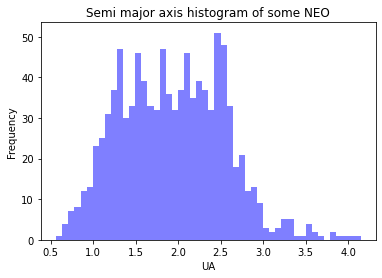

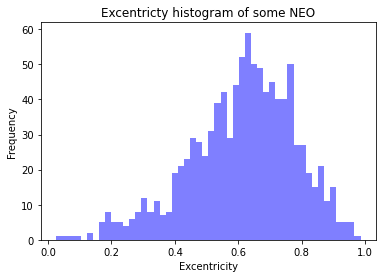

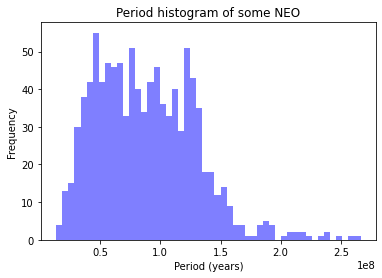

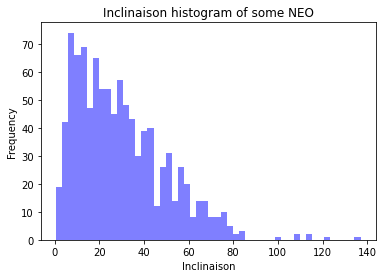

In [55]:

plt.hist(neos1000['a'],bins=50,facecolor='blue', alpha=0.5)
plt.xlabel('UA')
plt.ylabel('Frequency')
plt.title('Semi major axis histogram of some NEO')
plt.show()

plt.hist(neos1000['e'],bins=50,facecolor='blue', alpha=0.5)
plt.xlabel('Excentricity')
plt.ylabel('Frequency')
plt.title('Excentricty histogram of some NEO')
plt.show()

plt.hist(compute_period_fromtraj(neos1000),bins=50,facecolor='blue', alpha=0.5)
plt.xlabel('Period (years)')
plt.ylabel('Frequency')
plt.title('Period histogram of some NEO')
plt.show()


plt.hist(neos1000['i'],bins=50,facecolor='blue', alpha=0.5)
plt.xlabel('Inclinaison')
plt.ylabel('Frequency')
plt.title('Inclinaison histogram of some NEO')
plt.show()

Now that we better understand NEOs ( Near Earth Objects ) that we want to detect, it is important to think of a strategy to detect as much NEO as we can. In this study the goal was to be able to detect 99.9% of NEO with a diameter larger than 100m.

#### SNR needed on telescope detectors

In order to maximize the Signal to Noise Ratio on detectors we decided to fix some detectors characteristics :

| Capacity | Size | IFOV | Dark Current |
| :-: | :-: | :-: | :-:|
| $75$*$10^3$ electrons | 10000*10000pix | 1.08 | 1 |

For the instrument we have :

| FOV | Diameter | Efficiency | Quantum Efficiency |
| :-: | :-: | :-: | :-:|
| 3°x3° | 1m | 0.8 | 0.9 |

In order to compute the SNR the time allowed per sky portion need to be known. Our satellite will be on a Venus like orbit, in order to simplify the study, it has been decided that in 1 period ( 224.7 days ) all the sky must have been scanned and a guard angle of 90° must be left between the sun and the line of sight.

In [56]:
def compute_scanning_time_m(time_to_scan_entier_sky,FOV):
    '''
    Parameters
    ----------
    time_to_scan_entier_sky : time allowed to scan entierely the sky (days)
    FOV : Field of view ( degree )
    
    Returns
    -------
    Time allowed per image
    '''    
    nb_pointing_horiz = 360/FOV
    nb_pointing_vert = 180/FOV
    return (time_to_scan_entier_sky / nb_pointing_horiz)/nb_pointing_vert

print('Time per sky portion (min):',compute_scanning_time_m(224.7,3)*60*24)

Time per sky portion (min): 44.94


In order to respect the criterion : scan all the sky in 1 period, we have 44min94s per sky portion ( 3°x3°).

With all these characteristics it is then possible to compute the signal to noise ratio :
\begin{align} \frac{S}{N} = \frac{FA_{\epsilon}\sqrt{\tau}}{(\frac{N_R^2}{\tau}+FA_{\epsilon}+i_{DC}+F_{\beta}A_{\epsilon}\Omega)^{\frac{1}{2}}}\end{align}  
  
with :  
- $F$ = point source signal flux
- $F_{\beta}$ = Background flux from sky
- $\Omega$ = Pixel size
- $\tau$ = Integration time
- $i_{DC}$ = Dark current
- $A_e=A\epsilon Q_e$
- $Q_e$ = Quantum efficiency
- $NR$ = Read out noise  
  
**Source** : *Notes for PHYS 134: Observational Astrophysics / Bill Wolf and Phil Lubin*

We computed with an excel table that for 1 image the SNR needed to have 99.9% probability of detection is 9.6 and for 2 images the SNR needed is 6.1.

As the SNR is related to the incoming flux, it is then possible to compute the minimum magnitude visible with our telescope in order to be capable of detecting an object with accuracy 99.9%. The aim is to maximize the limit detectable magnitude in order to be able to detect fainter objects. After an optimization study, on either doing lot of image with small integration time or longer but fewer images, the chosen strategy is the following :

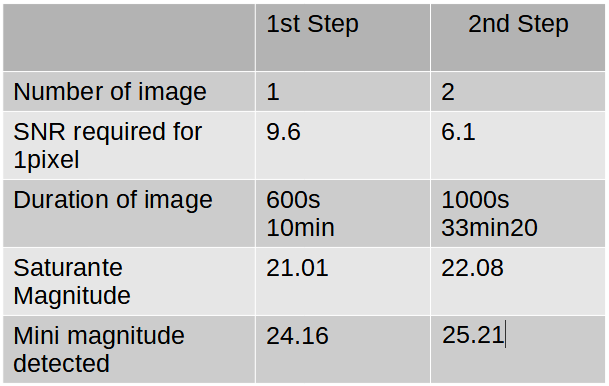

In [57]:
Image("strategie.png",width=300)

The limit magnitude detected is 25.27. That is to says, a 100m diameter asteroid would be visible under the dark curve which corresponds to apparent magnitude 25.21 :

<ipython-input-58-1e0345ca8432>:11: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(X, Y, mag_app)


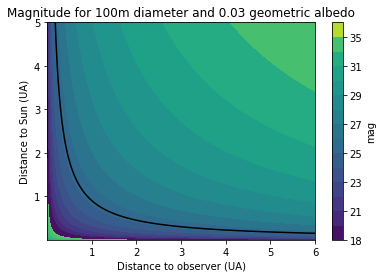

In [58]:
# 100m asteroid
D_SUN = np.linspace(0.00001,6,1000)
D_OBS = np.linspace(0.00001,5,1000)

X, Y = np.meshgrid(D_SUN, D_OBS)

mag_abs=D_to_abs_mag(0.1,0.03)
mag_app = abs_mag_to_mag(mag_abs,X,Y)

fig, ax = plt.subplots()
plt.pcolor(X, Y, mag_app)
level = [18,20,21,22,23,24,25,26,27,28,29,30,31,32,35,40]
cs = ax.contourf(X, Y, mag_app,level)
cs2 = ax.contour(cs,levels=[25.21],colors="black" )

cbar = fig.colorbar(cs)
cbar.ax.set_ylabel('mag')
plt.xlabel('Distance to observer (UA)')
plt.ylabel('Distance to Sun (UA)')
plt.title('Magnitude for 100m diameter and 0.03 geometric albedo')
plt.show()

#### Study of asteroid visibility windows

Now that we have the limit magnitude detected it can be interessant to ask the question : How long asteroids are detectable ? 

In order to do this, we will use Kepler second law ( area law ). For a given radius of position on the ellipse we have : 
\begin{align} r = \frac{p}{1+ecos(\theta)}\end{align} 
  
  
The area of a section of an ellispe can be compute :
\begin{align} A = \int_{\theta_1}^{\theta_2}\frac{1}{2}r^2d\theta\end{align} 


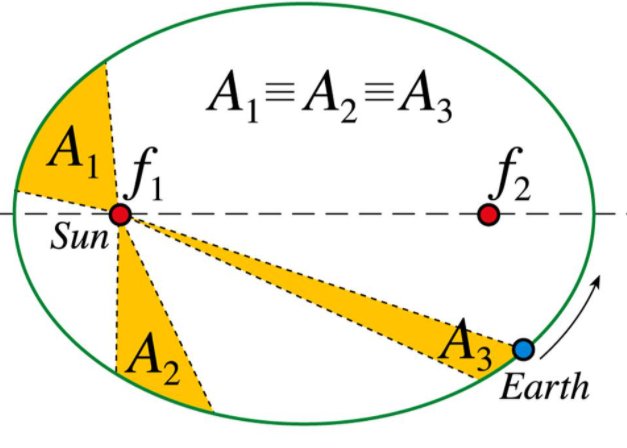

In [59]:
Image("aire.png",width=300)

In order to compute time spend by the asteroid in this area we use the 2nd Kepler law :
\begin{align} \frac{dA}{dt}=\frac{C}{2}\end{align}   
  
With  $C=r^2\theta = v_{perihelion}*r_{perihelion} = \sqrt{\mu a (1+e)(1-e)}$

In [60]:
def compute_period_fromtraj(neo):
    '''
    Parameters
    ----------
    neo : for a dataframe containing keplerian parameters of neo(s)
    
    Returns
    -------
    T : orbital period using Kepler 3rd law T**2/a**3 = 4pi**2/MG
    '''        
    M = 1.989*10**30    # Solar mass
    G = 6.67*10**(-11)
    
    a = neo['a']
    
    if isinstance(a,float):
        a_axe = np.sqrt(4*np.pi**2*(a*1.496*10**(11))**3/(G*M))
    
    else:
        a_axe = []
        for i in range(len(neo)):
            a_axe.append(np.sqrt(4*np.pi**2*(a[i]*1.496*10**(11))**3/(G*M)))
   
        
   
    return a_axe

In [61]:
def compute_b_from_ae(neo):
    '''
    Parameters
    ----------
    neo : a dataframe containing keplerian parameters of neo(s)
    
    Returns
    -------
    b : Semi minor axis ( same units as a, /!\ could be in UA )
    '''
    return neo['a']*np.sqrt(1-neo['e']**2)

In [62]:
def compute_theta_from_dist(dist,neo):
    '''
    Parameters
    ----------
    dist : distance between NEO and Sun ( UA )
    neo : a dataframe containing keplerian parameters of neo(s)
    
    Returns
    -------
    theta : angle between apogee and actual position 
    '''    
    # dist en UA
    dist = dist*1.496*10**(11)     # in m
    a = neo['a']*1.496*10**(11)
    e = neo['e']
    b = compute_b_from_ae(neo)*1.496*10**(11)
    p = b**2/a
    return np.arccos((dist-p)/(dist*e))

In [63]:
def compute_theta_from_dist(dist,neo):
    '''
    Parameters
    ----------
    dist : distance between NEO and Sun ( UA )
    neo : a dataframe containing keplerian parameters of neo(s)
    
    Returns
    -------
    theta : angle between apogee and actual position 
    '''    
    # dist en UA
    dist = dist*1.496*10**(11)     # in m
    a = neo['a']*1.496*10**(11)
    e = neo['e']
    b = compute_b_from_ae(neo)*1.496*10**(11)
    p = b**2/a
    return np.arccos((dist-p)/(dist*e))

In [64]:
def arealaw_constant(neo):
    '''
    Parameters
    ----------
    neo : a dataframe containing keplerian parameters of neo(s)
    
    Returns
    -------
    C : constant of the 2nd Kepler law ( area law )
    '''       
    mu = G*M
    a = neo['a']*1.496*10**(11)
    e = neo['e']
    return np.sqrt(mu*a*(1+e)*(1-e))

In [65]:
def r2(a,b,e,theta):
    p = b**2/a
    return 1/2*(p/(1-e*np.cos(theta)))**2

##### Link between Sun distance and satellite distance

As mentionned before, in order to compute how much time an asteroid will stay in visible area ( in function of its diameter and orbit ) it is necessary to compute the distance from Sun at which it will become visible given the limit magnitude. But to deduce a distance from Sun it is necessary to have the distance from observer. 

We will then simplify the study. As mentionned before, we decided to consider a Venus like orbit ( $a = 0.7$ UA, e~0 ) for our satellite, considering that it is possible to detect the asteroid at $n$UA and as we want to keep a 90° angle with the Sun, we are in this configuration :

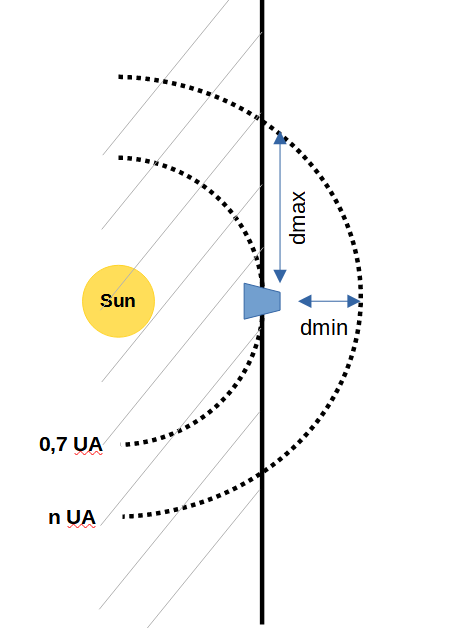

In [66]:
Image("dist_obs_max_min.png",width=300)

That is to say that if an asteroid is visible at nUA from the Sun it is at a maximum distance $d_{max} = \sqrt{nUA^2-0.7^2}$ ( worst case ) from satellite and minimum distance of $d_{min}=nUA - 0.7$ ( best case ). With this simplification, it will be easier to compute the time of visible area for each asteroid. We will consider a best case, a worst case and an average case.

It then now possible from the 1000neos catalogue to compute for each neo the distance from the Sun at which they are visible ( in the best case $ d_{min} $, worst case $d_{max}$ and average case $mean(d_{min},d_{max})$). Then it is possible to deduce with the area of an ellipse portion and 2nd kepler law the time spend for each asteroid in the visibility zone : distance from Sun for which the apparent magnitude is smaller than $25.21$.

In [67]:
def time_nUA_to_peri(dist,neo):
    '''
    Parameters
    ----------
    neo : a dataframe containing keplerian parameters of neo(s)
    dist [UA] : dist from Sun
    
    Returns
    -------
    Compute time to go from dist UA to perihelion
    '''    
    theta = compute_theta_from_dist(dist,neo)
    a = neo['a']*1.496*10**(11)
    e = neo['e']
    
    b = compute_b_from_ae(neo)*1.496*10**(11)
    
    if isinstance(a,float):
        area, err = quad(lambda x : r2(a,b,e,x), np.pi, theta)
      
    else:
        
        area = np.zeros(len(neo['a']))
        for i in range(len(neo['a'])):
        
            area[i], err = quad(lambda x : r2(a[i],b[i],e[i],x), np.pi, theta[i])
   
    C = arealaw_constant(neo)
    period = compute_period_fromtraj(neo)
    airetot = np.pi*a*b
    
    return period - 2/C*(airetot - np.abs(area)) 

In [68]:
def dist_maxmin_nUAsun_kUAobs(distSUN,print_dist=False):
    '''
    We want to keep a 90 degree angle with the Sun, so if the asteroid is at
    nUA from the Sun and is visible we can deduce the asteroid max distance to observer
    and asteroid min distance to the observer
    '''
    
    dist_min = distSUN - 0.7
    dist_max = np.sqrt(distSUN**2-0.7**2)
    if print_dist :
        print('Distance max to observer if {} to SUN : '.format(distSUN),dist_max)
        print('Distance min to observer if {} to SUN : '.format(distSUN),dist_min)
    return dist_min,dist_max
    

In [69]:
def time_inside_visible_area_astero(neo,magnitude_lim,case='best'):
    '''
    Parameters
    ----------
    neo : a dataframe containing keplerian parameters of neo(s)
    magnitude_lim : limite magnitude detectable by satellite
    
    Returns
    -------
    Compute time inside visible area, different for each asteroide depending on size and keplerian parameters
    '''    
    d_SUN = np.linspace(0.7,8,3000)
    s = 0
    visible_time = []
    for k in range(len(neo['a'])):
        
        neok = neo.iloc[k]
        H = neok['H']
        visible_dist = []
        visible_dist_nb = 0
        for i in range(len(d_SUN)):
            
            # Compute visible distance
            d_SUNi = d_SUN[i]
            d_min , d_max = dist_maxmin_nUAsun_kUAobs(d_SUNi)
            
            if case == 'best':
                d_to_obs = d_min
            if case == 'worst':
                d_to_obs = d_max
            if case == 'average':
                d_to_obs = np.mean([d_min,d_max])
                
            magapp = abs_mag_to_mag(H, d_SUNi, d_to_obs)
    
            if ( magapp < magnitude_lim + 0.01 and magapp > magnitude_lim - 0.01):
                visible_dist.append( d_SUNi )
            
        if len(visible_dist) > 0 :
            visible_dist_nb = np.max(visible_dist)
       
        else :
            print('## Either the asteroid is never visible ##')
            print('/!\ Or the d spacing must be changed, or magnitude range comparision')
            s = s+1
            
        if visible_dist_nb != 0 :
            if visible_dist_nb > neok['a']*(1+neok['e']):
                a=0 # if visible distance > apogee
                #visible_time.append(compute_period_fromtraj(neok)/(60*60*24))
            else :
                if abs_mag_to_D(H,0.03)<100:
                    a=0
                else :
                    # 2*(Compute time to go from visible distance to perihelion)
                    visible_time.append(2*time_nUA_to_peri(visible_dist_nb,neok)/(60*60*24))
     
    print(s)    
    return visible_time   

<ipython-input-50-b07c2c496f18>:15: RuntimeWarning: divide by zero encountered in log10
  return H + 5*np.log10(d_sun_ast*d_obs_ast) - 2.5*np.log10(q)


0


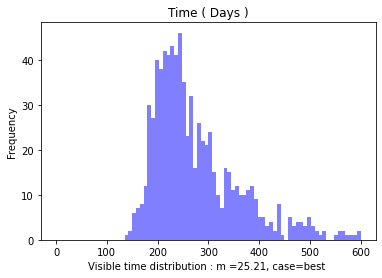

In [70]:
case = 'best'
lim_mag = 25.21
visible_times = time_inside_visible_area_astero(neos1000,lim_mag,case)
plt.hist(visible_times,bins=80,range=[0,600],facecolor='blue', alpha=0.5)
plt.xlabel('Visible time distribution : m ={}, case={} '.format(lim_mag,case))
plt.ylabel('Frequency')
plt.title('Time ( Days )')
plt.show()   


<ipython-input-50-b07c2c496f18>:15: RuntimeWarning: divide by zero encountered in log10
  return H + 5*np.log10(d_sun_ast*d_obs_ast) - 2.5*np.log10(q)


0


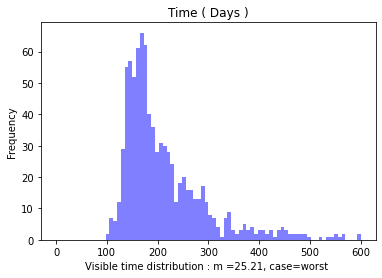

In [71]:
case = 'worst'
lim_mag = 25.21
visible_times = time_inside_visible_area_astero(neos1000,lim_mag,case)
plt.hist(visible_times,bins=80,range=[0,600],facecolor='blue', alpha=0.5)
plt.xlabel('Visible time distribution : m ={}, case={} '.format(lim_mag,case))
plt.ylabel('Frequency')
plt.title('Time ( Days )')
plt.show()   


<ipython-input-50-b07c2c496f18>:15: RuntimeWarning: divide by zero encountered in log10
  return H + 5*np.log10(d_sun_ast*d_obs_ast) - 2.5*np.log10(q)


0


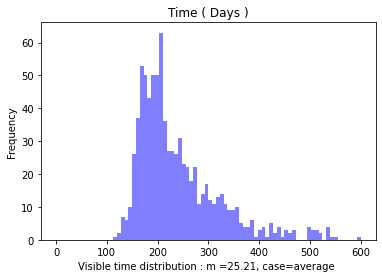

In [72]:
case = 'average'
lim_mag = 25.21
visible_times = time_inside_visible_area_astero(neos1000,lim_mag,case)
plt.hist(visible_times,bins=80,range=[0,600],facecolor='blue', alpha=0.5)
plt.xlabel('Visible time distribution : m ={}, case={} '.format(lim_mag,case))
plt.ylabel('Frequency')
plt.title('Time ( Days )')
plt.show()   


This visible time has to be compared with the satellite period 224.7days. The best case would be that visility time for asteroid is longer than satellite period ( 224.7days ) in order to be able to be sure to detect the asteroid 1 time at least in a period. But this is not the case that is why this study is completed by propagating orbits on CelestLab ( CNES ) in order to determine more precisely the probability to detect an asteroid with this strategy.


#### If all the 1000ateroids where 100m diameter

In order to complete the study we will assume that we are always in the worst case :
- all the asteroid are 100m diameter and $p_v = 0.03$ ( worst case ) and $p_v=0.15$ ( best case )

In [73]:


def time_inside_visible_area_100m_astero(neo,magnitude_lim):
    '''   /!\ Similar to previous function but here we assume each asteroid is 100m diameter ( in order to consider a worst case )
    Parameters
    ----------
    neo : a dataframe containing keplerian parameters of neo(s)
    magnitude_lim : limite magnitude detectable by satellite
    
    Returns
    -------
    Compute time inside visible area, different for each asteroide depending keplerian parameters
    '''        
    d_SUN = np.linspace(0.1,8,3000)
    dist = []
    s = 0
    visible_time_min = []
    visible_time_max = []
    
    pv_max = 0.15
    pv_min = 0.03
    D = 0.100
    H_min = D_to_abs_mag(D,pv_min)
    H_max = D_to_abs_mag(D,pv_max)
    
    for k in range(len(neo['a'])):
        
        neok = neo.iloc[k]
        
        visible_dist_min = []
        visible_dist_min_nb = 0
        
        visible_dist_max = []
        visible_dist_max_nb = 0
        
        for i in range(len(d_SUN)):
            d_SUNi = d_SUN[i]
            d_min , d_max = dist_maxmin_nUAsun_kUAobs(d_SUNi)
            
            magapp_min = abs_mag_to_mag(H_min, d_SUNi, d_min)
           
            magapp_max = abs_mag_to_mag(H_max, d_SUNi, d_min)
           
            if ( magapp_min < magnitude_lim + 0.01 and magapp_min > magnitude_lim - 0.01):
                visible_dist_min.append( d_SUNi )
             
            if ( magapp_max < magnitude_lim + 0.01 and magapp_max > magnitude_lim - 0.01):
                visible_dist_max.append( d_SUNi )
            
        if len(visible_dist_min) > 0 :
            visible_dist_min_nb = np.max(visible_dist_min)
            visible_dist_max_nb = np.max(visible_dist_max)
       
        else :
            print('## Either the asteroid is never visible ##')
            print('/!\ Or the d spacing must be changed, or magnitude range comparision')
            s = s+1
            
        if visible_dist_min_nb != 0 :
            if visible_dist_min_nb > neok['a']*(1+neok['e']):
                a=0
                #visible_time_min.append(compute_period_fromtraj(neok)/(60*60*24))
            else :
                visible_time_min.append(2*time_nUA_to_peri(visible_dist_min_nb,neok)/(60*60*24))
        
        if visible_dist_max_nb != 0 :
            if visible_dist_max_nb > neok['a']*(1+neok['e']):
                a=0
                #visible_time_max.append(compute_period_fromtraj(neok)/(60*60*24))
            else :
                visible_time_max.append(2*time_nUA_to_peri(visible_dist_max_nb,neok)/(60*60*24))
     
    print(s)    
    return visible_time_min , visible_time_max   


<ipython-input-68-a08a1ec0eea4>:9: RuntimeWarning: invalid value encountered in sqrt
  dist_max = np.sqrt(distSUN**2-0.7**2)
<ipython-input-50-b07c2c496f18>:15: RuntimeWarning: invalid value encountered in log10
  return H + 5*np.log10(d_sun_ast*d_obs_ast) - 2.5*np.log10(q)


0


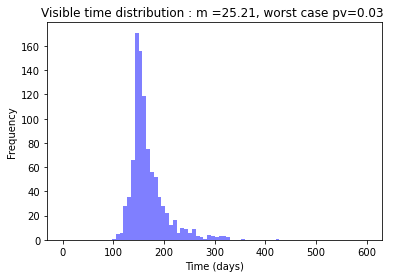

In [74]:
lim_mag = 25.21

visible_times_100m_min,visible_times_100m_max = time_inside_visible_area_100m_astero(neos1000,lim_mag)

plt.hist(visible_times_100m_min,bins=80,range=[0,600],facecolor='blue', alpha=0.5)
plt.xlabel('Time (days)')
plt.ylabel('Frequency')
plt.title('Visible time distribution : m ={}, worst case pv=0.03 '.format(lim_mag))
plt.show()   


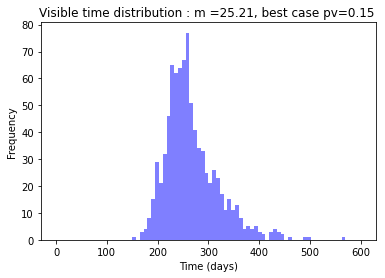

In [75]:

plt.hist(visible_times_100m_max,bins=80,range=[0,600],facecolor='blue', alpha=0.5)
plt.xlabel('Time (days)')
plt.ylabel('Frequency')
plt.title('Visible time distribution : m ={}, best case pv=0.15 '.format(lim_mag))
plt.show()   


This approach has some limits, we can deduce here the detection probability of detecting a NEO or we cannot estimate how much before impact we can detect an asteroid. That is why we added to this study some orbit propagation on CelestLab.

## References  

Asteroid size : 
- *Multiple asteroid systems: Dimensions and thermal properties from Spitzer Space Telescope and ground-based observations / F. Marchis*


Detection Probability : 
- *Survey Simulations of a new near-Earth asteroid detection systeme / A. Mainzer*
- *Detection Systems, Institut d'Optique Graduate School / Julien Moreau and Riad Haïdar*
- *Notes for PHYS 134: Observational Astrophysics / Bill Wolf and Phil Lubin*